In [3]:
polygon_ID = 252

# Import data, identify contours and convert to points

ITEM classes: [-9999, -2296, -1709, -1142, -449, 135, 824, 1387, 2036, 2669]


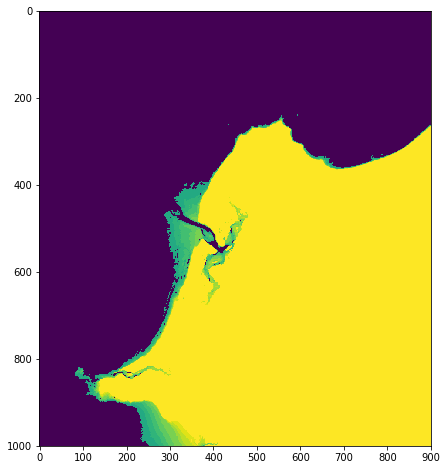

In [4]:
# Import libraries
import datacube
import glob
import scipy.ndimage
import fiona
import numpy as np
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology
import matplotlib.cm as cm
from shapely.geometry import Point, LineString, MultiLineString, mapping
from fiona.crs import from_epsg
from osgeo import gdal
from scipy.interpolate import griddata
from skimage import measure
from matplotlib import pyplot as plt

"""
TODO: Investigate scipy.interpolate.RectBivariateSpline, scipy.interpolate.interp2d,
spipy.interpolate.RegularGridInterpolator, sklearn.gaussian_process.GaussianProcess
"""


def write_geotiff(fname, data, geo_transform, projection, nodata_val):
    
    """
    Create a single band GeoTIFF file with data from array.
    
    :attr fname: output file path
    :attr data: input array
    :attr geo_transform: geotransform for output raster
    :attr projection: projection for output raster
    :attr nodata_val: value to convert to nodata in output raster
    """
    
    # Set up driver
    driver = gdal.GetDriverByName('GTiff')
    
    # Create raster of given size and projection
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Float32)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    
    # Write data to array and set nodata values
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    band.SetNoDataValue(nodata_val)
    
    # Close file
    dataset = None     
   


# Zoom-in for plots (has no effect on analysis but allows you to plot a zoomed-in subset)
# plotting_subset = np.index_exp[:, :]
plotting_subset = np.index_exp[1100:2100, 1300:2200]

# Import raster and extract shape, projection info and geotransform data
filename = glob.glob("/g/data2/v10/ITEM/offset_products/ITEM_OFFSET_{}_*.tif".format(polygon_ID))[0]
src_ds = gdal.Open(filename)
srcarray = src_ds.GetRasterBand(1).ReadAsArray() 
yrows, xcols = srcarray.shape
prj = src_ds.GetProjection()
geotrans = src_ds.GetGeoTransform()
upleft_x, x_size, x_rotation, upleft_y, y_rotation, y_size = geotrans

# Copy original data so array can be modified 
item_array = np.copy(srcarray)

# Set nodata to NaN, and force 0 values to a low negative  (-9999) to allow correct 
# contour extraction (i.e. make "0" data sit beneath the lowest ITEM tidal stage)
item_array[item_array == -6666] = np.nan
item_array[item_array == 0] = -9999 

# Import elevation values from file
elevations = np.loadtxt("/g/data2/v10/ITEM/offset_products/elevation.txt", delimiter = ",", dtype = "str")
elev_dict = {int(key):[int(val) for val in value.split(" ")] for (key, value) in elevations}
item_classes = [-9999] + elev_dict[polygon_ID]
print("ITEM classes: {}".format(item_classes))

# Plot original data
plt.figure(figsize = (8, 8))
plt.imshow(item_array[plotting_subset])  
plt.show()


# Extract contours

In [5]:
# Set up output list and items to iterate over; subtract 1m from highest class to allow
# highest contour to calculate (otherwise, this height is read as being in NaN area)
contour_classes = item_classes[0:9] + [item_classes[9] - 1.0]

# Output dict
contour_dict = {}

for n, contour_class in enumerate(contour_classes):
    
    # Extract contours from array
    contours = measure.find_contours(item_array, contour_class)  

    # Iterate through each contour feature, remove NAs and fix coordinates
    contour_list = list()
    for contour in contours:

        # Remove contour points with NAs
        contour = contour[~np.isnan(contour).any(axis=1)] 

        # Convert cells to array of points; use geotransform to convert indices to coordinates in metres
        y_inds, x_inds = contour[:,0], contour[:,1]
        contour = [(y_ind * float(y_size) + upleft_y + (float(y_size) / 2),
                    x_ind * float(x_size) + upleft_x + (float(x_size) / 2)) for (y_ind, x_ind) in contour]    
        contour_list.append(contour)
        
    # Add elevation values and contours with at least one point to dict
    elevation_value = item_classes[np.min((9, n + 1))]
    contour_dict[elevation_value] = [x for x in contour_list if len(x) > 0]

    
# Export points to shapefile
schema = {'geometry':  'MultiLineString', 
            'properties': { 'elevation': 'int' } }      

with fiona.open("output_data/ITEM_DEM_{}_lines.shp".format(polygon_ID), "w", 
                crs = from_epsg(3577),
                driver = "ESRI Shapefile", 
                schema = schema) as output:
    
    for elevation_value, contour_list in contour_dict.items():
        
        # For line shapefile export, keep only arrays with at least two points (to make lines)
        contour_list = [x for x in contour_list if len(x) > 0]
        
        # For each array of contour points, flip x and y then create line string
        contour_linestrings = [LineString([(x, y) for (y, x) in contour_array]) for contour_array in contour_list]
        contour_multilinestring = MultiLineString(contour_linestrings)

        # Write output shapefile to file with elevation field        
        output.write({'properties': { 'elevation': elevation_value },
                      'geometry': mapping(contour_multilinestring) })
        
        
# Convert to arrays for interpolation
# points = np.array(centroids)
# values = np.array(alldata[:,2])

In [ ]:
from shapely.geometry import Point, MultiLineString, mapping
contours[0]


# Interpolate points
Exports a DEM by interpolating previously extracted contours. This uses the `linear` method from `scipy.interpolate.griddata`, which computes a TIN/Delaunay triangulation of the input data using [Qhull](www.qhull.org) before performing linear barycentric interpolation on each triangle.

In [ ]:
# Extract bounds of ITEM layer
minx = upleft_x
maxx = upleft_x + (x_size * xcols)
miny = upleft_y + (y_size * yrows)
maxy = upleft_y

# Create interpolation grid (from, to, by in metres)
grid_y, grid_x = np.mgrid[maxy:miny:1j * yrows,
                          minx:maxx:1j * xcols]

# Interpolate between points onto grid. This uses the 'linear' method from 
# scipy.interpolate.griddata, which computes a TIN/Delaunay triangulation of the input 
# data with Qhull and performs linear barycentric interpolation on each triangle
interpolated_array = griddata(points, values, (grid_y, grid_x), method = "linear")

# Mask out NaNs, zero values and max tidal stage from original ITEM offset layer
gooddata_mask = ((srcarray != -6666) & (srcarray != 0) & (srcarray != item_classes[9]))
interpolated_array[~gooddata_mask] = np.nan

# # Plot
# plt.figure(figsize = (8, 8))
# plt.imshow(interpolated_array[plotting_subset])
# plt.show()

# Export to tif
write_geotiff(fname = "output_data/ITEM_DEM_{}.tif".format(polygon_ID), 
              data = interpolated_array, 
              geo_transform = geotrans, 
              projection = prj, 
              nodata_val = np.nan)
